In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from warnings import filterwarnings

filterwarnings('ignore')

%matplotlib inline

sns.set(style="darkgrid")
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [162]:
! pip install --upgrade category_encoders

In [163]:
import category_encoders as ce

**Task 1**. We will be working with data from the [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) competition, which was about predicting the duration of a taxi trip. Download the training sample from this competition and upload it:

In [164]:
train = pd.read_csv('train1.csv')
train_new = pd.read_csv('train1.csv')

In [76]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Understanding the data

In [31]:
train.describe

<bound method NDFrame.describe of                 id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0 

Pay attention to the `pickup_datetime` and `dropoff_datetime` columns. `dropoff_datetime` was added only to the training sample, so, this column cannot be used, let's delete it. `pickup_datetime` contains the date and time the trip started. To make it convenient to work with, let's convert dates to `datetime` objects

In [165]:
train = train.drop('dropoff_datetime', axis=1)
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)

target = 'trip_duration'

In [166]:
train_new = train_new.drop('dropoff_datetime', axis=1)
train_new['pickup_datetime'] = pd.to_datetime(train_new.pickup_datetime)

The `trip_duration` column contains the target value we want to predict. Let's look at the distribution of the target in the training sample. To do this, draw its histogram:

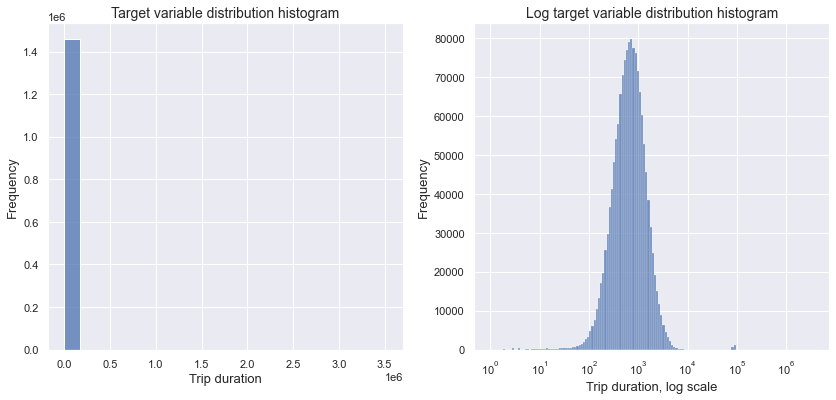

In [57]:
plt.rcParams["figure.figsize"] = (14,6)

fig, ax = plt.subplots(ncols=2)

sns.histplot(data=train, x=target, bins=20, ax=ax[0])
#plot similar histogram with parameter log_scale, choose informative amount of bins and correct axis
#your code here
sns.histplot(data=train, x=target, bins=150, log_scale=True, ax=ax[1])
#OR
#train['trip_duration_normalised'] = np.log(train['trip_duration'].values + 1)
#graph = sns.histplot(train["trip_duration_normalised"], bins = 200)
#graph.set(xlabel='Trip duration', ylabel='Frequency')
#end of your code

ax[0].set_title('Target variable distribution histogram', dict(size=14))
ax[0].set_xlabel('Trip duration', dict(size=13))
ax[0].set_ylabel('Frequency', dict(size=13))

ax[1].set_title('Log target variable distribution histogram', dict(size=14))
ax[1].set_xlabel('Trip duration, log scale', dict(size=13))
_ = ax[1].set_ylabel('Frequency', dict(size=13))

**Question**: Why is it necessary to build a histogram in a logarithmic scale?

**Answer** To depict frequency distribution and to summarize both continuous and discrete data. It also helps to check for skewness towards large values.

The competition used RMSLE as a quality metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Question**: Why do you think the contest authors chose RMSLE and not RMSE?

**Answer** RMSLE is for relative error, while RMSE is an absolute error. In RMSE, the presence of outliers can explode the error term to a very high value. But, in RMLSE the outliers are scaled down therefore almost nulling their effect. Also in RMSLE higher penalty is incurred when the predicted value is less than the actual value. 

We have discussed several linear regression models in `sklearn`, but each of them optimized the mean square error (MSE), not RMSLE. Let's do the following trick: we will predict not the target variable, but its *logarithm*. Let $\hat{y}_i = \log{(y_i + 1)}$ be the modified target, and $\hat{a}(x_i)$ be the prediction of the model trained on $\hat{y}_i$, that is, the logarithm of the target. To predict the original value, we can simply take the exponent of our prediction: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

In addition, the logarithm of the target has another useful quality. To see it, add the `log_trip_duration` column to our sample (use `np.log1p`) and draw a histogram of the modified target for the training sample. Delete the column with the old target.

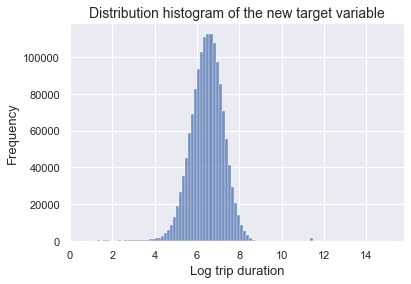

In [167]:
train['log_trip_duration'] = np.log1p(train[target])
#your code to delet target column from train is here:
train.drop(target,axis=1, inplace=True)
#end of your code
target = 'log_trip_duration'

plt.title('Distribution histogram of the new target variable', dict(size=14))
plt.xlabel('Log trip duration', dict(size=13))
plt.ylabel('Frequency', dict(size=13))
_ = sns.histplot(data=train, x=target, bins=100)

Let's calculate the value of the metric with the best constant prediction:

**Question**: why the best constant for RMSE is mean value?

**Answer**: It indicates the absolute fit of the model to the data and both RMSE and MAE provides average model prediction error in units of the target variable. But in RMSE since the errors are squared before they are averaged, RMSE gives a relatively high weight to large errors.

In [168]:
def RMSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** .5

In [169]:
#Droping pickup datetime in the intial model:
dropcols=[target, "id", "pickup_datetime", "store_and_fwd_flag", "id", "vendor_id"]

In [170]:
train["store_and_fwd_flag"].value_counts()
train["store_and_fwd_flag1"]=np.where(train.store_and_fwd_flag == "Y", 1, 0)

train["store_and_fwd_flag1"].value_counts()

0    1450599
1       8045
Name: store_and_fwd_flag1, dtype: int64

In [171]:
#your code to find constant prediction here:
const_model = LinearRegression()

const_model.fit(train.drop(dropcols, axis=1), train[target])

#end of your code
print('Best constant prediction value: {}'.format(RMSE(train[target], const_model.predict(train.drop(dropcols, axis=1)))))

Best constant prediction value: 0.77974979781037


**Task 2**. First, let's see how many trips there were on each day. Plot the number of trips versus the day of the year:

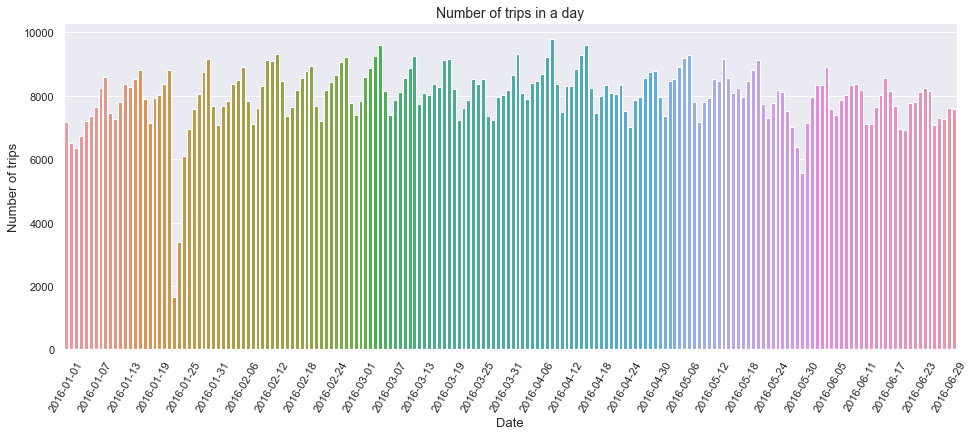

In [215]:
plt.rcParams["figure.figsize"] = (16,6)
train['day_of_year'] = train.pickup_datetime.dt.day_of_year

sns.countplot(x=train['day_of_year'])

plt.title('Number of trips in a day', dict(size=14))
plt.xlabel('Date', dict(size=13))
plt.ylabel('Number of trips', dict(size=13))

_ = plt.xticks(np.arange(0, 181, 6), np.unique(train.pickup_datetime.dt.date)[::6], rotation=60)

**Question**: You may have noticed that there are 2 periods on the graph with abnormally low numbers of trips. Calculate the dates on which these downward swings occurred and find information about what happened on those days in New York.

**Answer**: From 23rd to 26th January and 26th May onwards had lower number of trips (30th May being lowest in May).
This was because atravel ban was instituted for New York City for January 23–24 due to a blizzard. And on 30th May because of the Memorial Day


Plot the number of trips versus the day of the week and the hours of the day (use `sns.relplot`):

In [172]:
train['hour'] = train.pickup_datetime.dt.hour
train['day_of_week'] = train.pickup_datetime.dt.day_of_week
train['day_of_year'] = train.pickup_datetime.dt.day_of_year
train['month_name'] = train.pickup_datetime.dt.month_name()

In [6]:
train.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,day_of_week,day_of_year,month_name
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,74,March
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,164,June
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,19,January


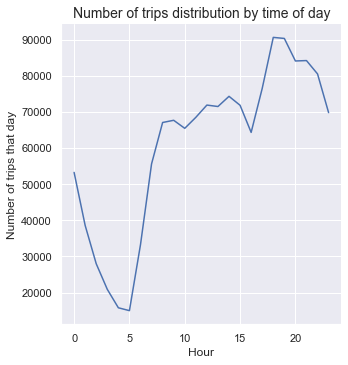

In [218]:
tmp_data = train.groupby('hour').id.count()\
.reset_index().rename({
    'hour': 'Hour',
    'id': 'Number of trips that day'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips that day',
            kind='line')
_ = plt.title('Number of trips distribution by time of day', dict(size=14))

In [219]:
tmp_data.head(5)

,Hour,Number of trips that day
0,0,53248
1,1,38571
2,2,27972
3,3,20895
4,4,15792


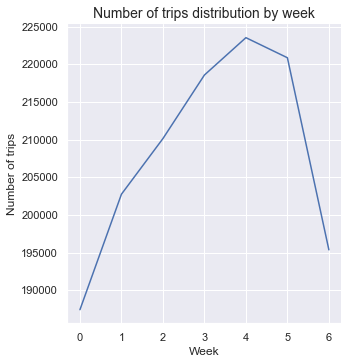

In [220]:
#your code for number of trips distribution by day of week

tmp_data = train.groupby('day_of_week').id.count()\
.reset_index().rename({
    'day_of_week': 'Week',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Week',
            y='Number of trips',
            kind='line')
_ = plt.title('Number of trips distribution by week', dict(size=14))
#end of your code

**Task 3**. Draw on one graph the dependence of the number of trips on the hour of the day for different months (different curves corresponding to different months, color in different colors with use of `hue` in `sns.relplot`). Similarly, draw the dependence of the number of trips on the hour of the day for different days of the week.

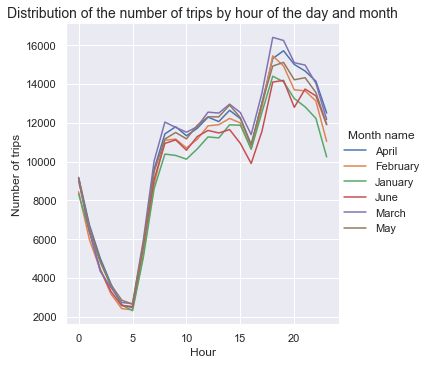

In [148]:
tmp_data = train.groupby(['month_name', 'hour']).id.count()\
.reset_index().rename({
    'month_name': 'Month name',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips',
            hue='Month name',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))

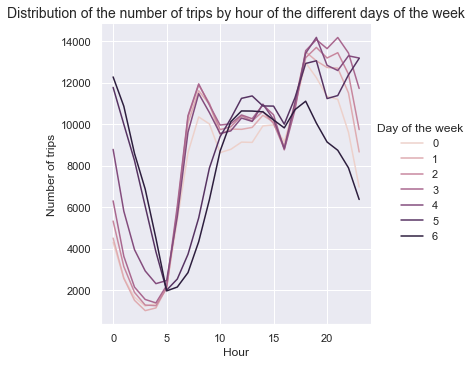

In [150]:
#your code for the dependence of the number of trips on the hour of the day for different days of the week is here:

tmp_data1 = train.groupby(['day_of_week', 'hour']).id.count()\
.reset_index().rename({
    'day_of_week': 'Day of the week',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data1,
            x='Hour',
            y='Number of trips',
            hue='Day of the week',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the different days of the week', dict(size=14))

#end of your code

**Question**: What conclusions can be drawn based on the graphs above? Are there any special days of the week? Months? Times of Day? What is it connected with?

**Answer**: The number of trips falls sharly in the early morning hours from midnight to 5AM for all months. After that the number of trips rise steeply from 5AM. This trend is similar across all months.

In the day of the week vs hours graph, we notice a higher count in trips taken on the weekends (early morning hours) indicative of people returning home late. While the number of trips taken drop in the second half of Sunday.

**Task 4**. Split the sample into train and test (7:3). For the train sample, plot the mean logarithm of travel time versus day of the week. Then do the same, but for the hour of the day and the day of the year.

Add the following traits based on `pickup_datetime`:
1. Day of the week
2. Month
3. Hour
4. Is the period anomalous (two binary signs corresponding to two anomalous periods)
5. Number of the day in the year

In [173]:
train = train.drop('month_name', axis=1)
train['month'] = train.pickup_datetime.dt.month

train['is_anomaly_jan'] = ((23 <= train.day_of_year) & (train.day_of_year <= 26)).astype('int')
train['is_anomaly_may'] = (train.day_of_year == 151).astype('int')

In [222]:
train.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag             object
log_trip_duration             float64
store_and_fwd_flag1             int64
day_of_year                     int64
hour                            int64
day_of_week                     int64
month                           int64
is_anomaly_jan                  int64
is_anomaly_may                  int64
dtype: object

In [174]:
dropcols1=[target, "pickup_datetime", "store_and_fwd_flag1"]
#your code for splitting is here:
X_train, X_test, y_train, y_test = train_test_split(train.drop(dropcols1, axis=1), train[target], test_size=0.3, random_state=10)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
#end of your code

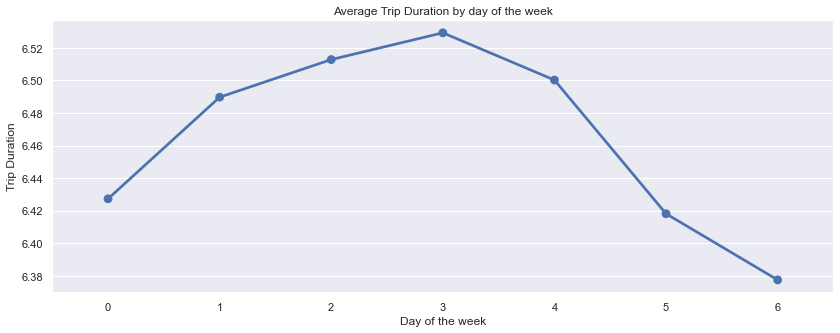

In [224]:
#your code for distribution of average trip duration by the number of day in a week is here:
plt.figure(figsize = (14,5))
group1 = train_data.groupby('day_of_week').log_trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration')
plt.xlabel('Day of the week')
plt.title('Average Trip Duration by day of the week')
plt.show()
#end of your code

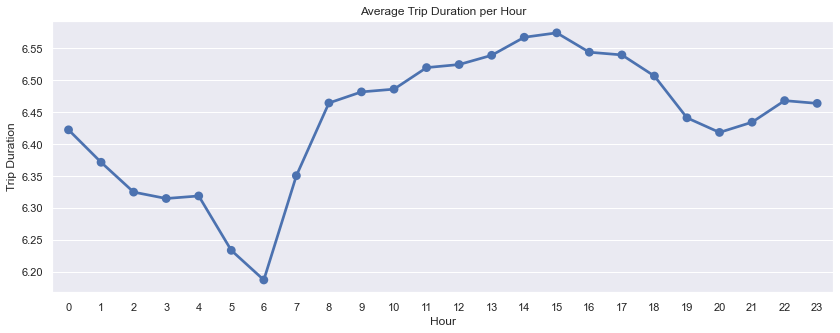

In [225]:
#your code for distribution of average trip duration by the hour of day is here:
plt.figure(figsize = (14,5))
group1 = train_data.groupby('hour').log_trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration')
plt.xlabel('Hour')
plt.title('Average Trip Duration per Hour')
plt.show()
#end of your code

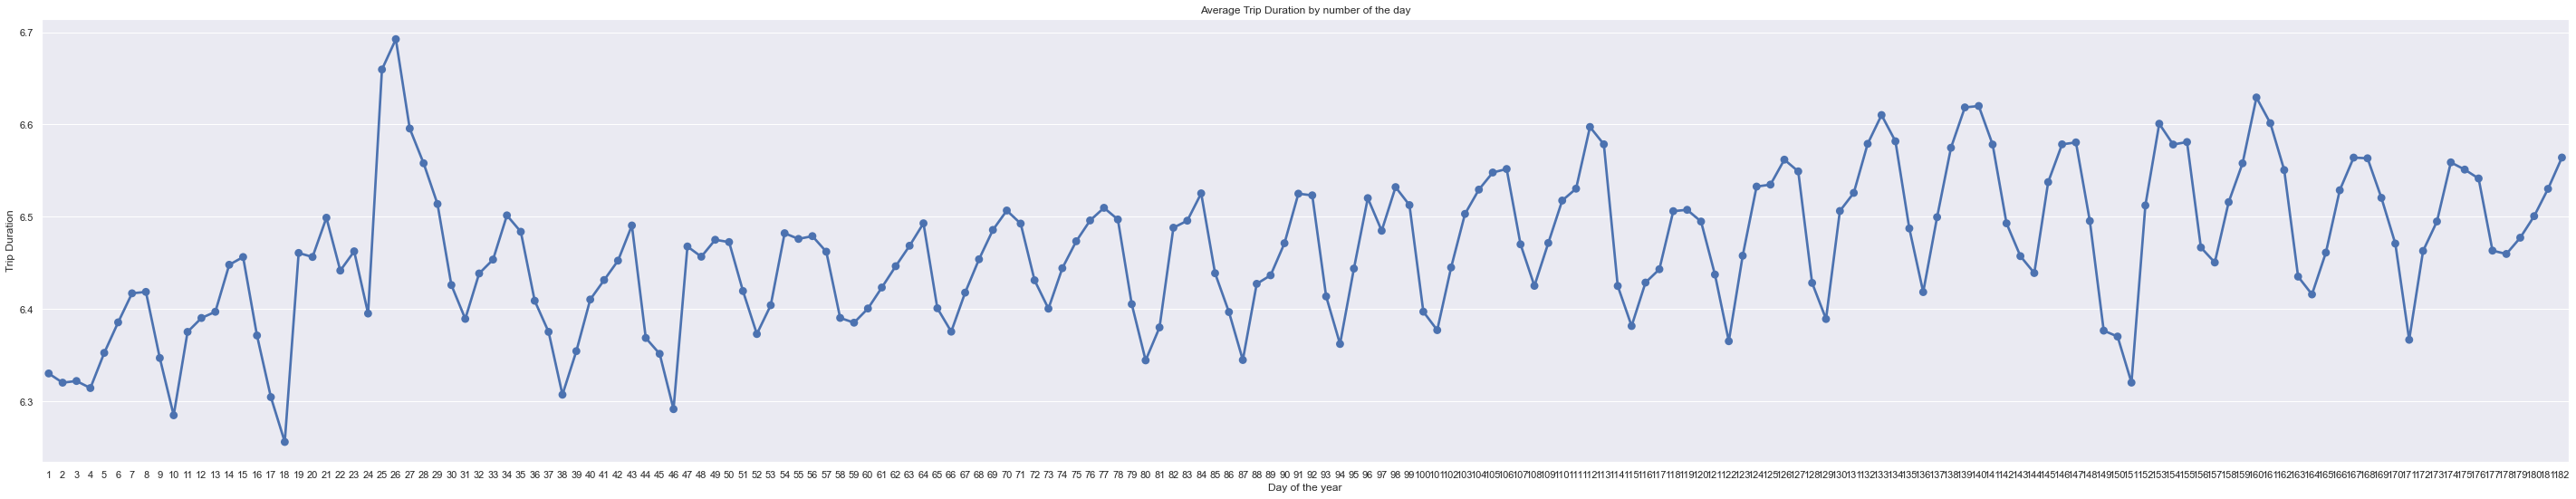

In [226]:
#your code for distribution of average trip duration by the number of day in the year is here:
plt.figure(figsize = (50,9))
group1 = train_data.groupby('day_of_year').log_trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration')
plt.xlabel('Day of the year')
plt.title('Average Trip Duration by number of the day')
plt.show()
#end of your code

**Question**: Are the graphs of the target depending on the day of the week and on the hour of the day similar to those for the number of trips? Why? What happens to the average target in those two anomalous periods that we saw above? Why is this happening? Do you see any trend in the plot of `log_trip_duration` versus day of the year?

**Answer**:The highest avg time taken to complete a trip is on Thursday while Monday, Saturday and Sunday takes the least time. The average duration of trips in between 14 hours and 16 hours is the largest.


So, we have already created a number of features.

**Question**: Which of the features should be considered as categorical, and which - as numerical? Why?

**Answer**:Continous variables should be considered numerical where variables like month, day of the week, store_and_fwd_flag must be considered as categorical. is_anomaly_jan is_anomaly_may are already binary.

In [227]:
train.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,store_and_fwd_flag1,day_of_year,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,N,6.122493,0,74,17,0,3,0,0


In [68]:
train_data.dtypes

id                     object
vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
hour                    int64
day_of_week             int64
day_of_year             int64
month                   int64
is_anomaly_jan          int64
is_anomaly_may          int64
log_trip_duration     float64
dtype: object

**Task 5**. Train `Ridge` regression with default parameters by encoding all categorical features with `OneHotEncoder`. Scale numerical features with `StandardScaler`. Use only the features that we have identified in this part of the task.

In [175]:
def make_pipeline(categorical, numeric, model):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler', StandardScaler())
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
          ('onehot', OneHotEncoder(handle_unknown="ignore"))

    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(train_data, train_data['log_trip_duration'])
#end of your code

    print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))

In [176]:
#your list of categorical features is here:
categorical_columns = ["day_of_week", "month", 'is_anomaly_jan', 'is_anomaly_may']
#your list of numerical features is here:
numeric_columns = ['day_of_year', 'hour']
#your code to create pipeline is here:
pipeline = make_pipeline(categorical_columns, numeric_columns, Ridge())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train_data, random_state=42, test_size=0.3))

Train RMSE is 0.7929921753901036
Test RMSE is 0.7925077265142669


In [177]:
train_new['hour'] = train_new.pickup_datetime.dt.hour
train_new['day_of_week'] = train_new.pickup_datetime.dt.day_of_week
train_new['day_of_year'] = train_new.pickup_datetime.dt.day_of_year
train_new['month_name'] = train_new.pickup_datetime.dt.month_name()

In [73]:
train.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag             object
store_and_fwd_flag1             int64
log_trip_duration             float64
hour                            int64
day_of_week                     int64
day_of_year                     int64
month                           int64
is_anomaly_jan                  int64
is_anomaly_may                  int64
dtype: object

**Task 6**. Try to use any other way of categorical features encoding and normalization for numerical features. Train `Ridge` and `Lasso` regression for various encoding options and evaluate the results. Which one turned out to be the best? Why did other options show worse quality?

In [178]:
#your code is here
#Backward Difference Encoding

encoder = ce.BackwardDifferenceEncoder(cols=["store_and_fwd_flag", "day_of_week", "month", "is_anomaly_jan", "is_anomaly_may"])
train_1 = encoder.fit_transform(train)

train_1.head()
#end of your code

,intercept,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag_0,log_trip_duration,store_and_fwd_flag1,hour,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_year,month_0,month_1,month_2,month_3,month_4,is_anomaly_jan_0,is_anomaly_may_0
0,1,id2875421,2,2016-03-14 17:24:55,1,-74,41,-74,41,-0.5,6.1,0,17,-0.86,-0.71,-0.57,-0.43,-0.29,-0.14,74,-0.83,-0.67,-0.5,-0.33,-0.17,-0.5,-0.5
1,1,id2377394,1,2016-06-12 00:43:35,1,-74,41,-74,41,-0.5,6.5,0,0,0.14,-0.71,-0.57,-0.43,-0.29,-0.14,164,0.17,-0.67,-0.5,-0.33,-0.17,-0.5,-0.5
2,1,id3858529,2,2016-01-19 11:35:24,1,-74,41,-74,41,-0.5,7.7,0,11,0.14,0.29,-0.57,-0.43,-0.29,-0.14,19,0.17,0.33,-0.5,-0.33,-0.17,-0.5,-0.5
3,1,id3504673,2,2016-04-06 19:32:31,1,-74,41,-74,41,-0.5,6.1,0,19,0.14,0.29,0.43,-0.43,-0.29,-0.14,97,0.17,0.33,0.5,-0.33,-0.17,-0.5,-0.5
4,1,id2181028,2,2016-03-26 13:30:55,1,-74,41,-74,41,-0.5,6.1,0,13,0.14,0.29,0.43,0.57,-0.29,-0.14,86,-0.83,-0.67,-0.5,-0.33,-0.17,-0.5,-0.5


In [179]:
numcols=["passenger_count", "day_of_year", "hour"]
drop_1 = ["intercept", "id", "pickup_datetime", "vendor_id","pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
target1 = 'log_trip_duration'

In [180]:
#your code is here
# define min max scaler
scaler = MinMaxScaler()
# transform data
train_2 = scaler.fit_transform(train_1[numcols])
train_1[numcols] = pd.DataFrame(train_2,columns=numcols)
#end of your code

In [181]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(train_1.drop(drop_1, axis=1), train_1['log_trip_duration'], test_size=0.3, random_state=10)
train_data1 = pd.concat([X_train1, y_train1], axis=1)
test_data1 = pd.concat([X_test1, y_test1], axis=1)

In [182]:
train_data1

,passenger_count,store_and_fwd_flag_0,log_trip_duration,store_and_fwd_flag1,hour,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_year,month_0,month_1,month_2,month_3,month_4,is_anomaly_jan_0,is_anomaly_may_0,log_trip_duration
824746,0.33,-0.5,7.1,0,0,0.14,-0.71,-0.57,-0.43,-0.29,-0.14,0.48,-0.83,-0.67,-0.5,-0.33,-0.17,-0.5,-0.5,7.1
645821,0.11,-0.5,6.9,0,0.87,0.14,0.29,0.43,0.57,0.71,-0.14,0.43,-0.83,-0.67,-0.5,-0.33,-0.17,-0.5,-0.5,6.9
691846,0.22,-0.5,7.6,0,0.78,0.14,0.29,0.43,0.57,0.71,-0.14,0.58,0.17,0.33,0.5,-0.33,-0.17,-0.5,-0.5,7.6
1147931,0.11,-0.5,6.9,0,0.61,0.14,0.29,0.43,0.57,0.71,0.86,0.46,-0.83,-0.67,-0.5,-0.33,-0.17,-0.5,-0.5,6.9
183569,0.11,-0.5,6.2,0,0.57,0.14,0.29,0.43,0.57,0.71,0.86,0.65,0.17,0.33,0.5,-0.33,-0.17,-0.5,-0.5,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348317,0.11,-0.5,5.2,0,0.22,0.14,0.29,0.43,0.57,0.71,0.86,0.73,0.17,0.33,0.5,0.67,-0.17,-0.5,-0.5,5.2
1154171,0.11,-0.5,8.8,0,0.83,0.14,0.29,0.43,0.57,-0.29,-0.14,0.083,0.17,0.33,-0.5,-0.33,-0.17,-0.5,-0.5,8.8
617841,0.11,-0.5,5,0,0.87,-0.86,-0.71,-0.57,-0.43,-0.29,-0.14,0.44,-0.83,-0.67,-0.5,-0.33,-0.17,-0.5,-0.5,5
1048548,0.11,-0.5,6.1,0,0.39,0.14,0.29,0.43,0.57,-0.29,-0.14,0.55,0.17,0.33,0.5,-0.33,-0.17,-0.5,-0.5,6.1


In [183]:
# Train the model - Ridge
ridgeR = Ridge(alpha = 10)
ridgeR.fit(X_train1, y_train1)
y_pred1 = ridgeR.predict(X_test1)

print(r2_score(y_test1, y_pred1))
print(RMSE(y_test1, y_pred1))

0.9999999997592242
1.2324931541570223e-05


In [184]:
#Lasso
lasso_model = Lasso(alpha=10).fit(X_train1,y_train1)
y_pred2 = lasso_model.predict(X_test1)

print(r2_score(y_test1, y_pred1))
print(RMSE(y_test1, y_pred1))

0.9999999997592242
1.2324931541570223e-05


Both the models give very good results, but it could be a case of overfitting as the techniques used for encoding and normalisation of the categorical and 
numerical variables could be causing this effect. These techniques are not preferred. Most common techniques are one hot encoding and standard scaler.
Another reason is the regularization parameter.

**Task 7**. Split the training sample into train and validation (8:2). On the validation set, find the optimal values of the regularization parameter (on a logarithmic grid) for `Ridge` and `Lasso`, measure the quality of the best obtained model on the test set.

In [185]:
drops_c = ["id", "pickup_datetime", "vendor_id","pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

In [186]:
#your code is here

X_train, X_test, y_train, y_test = train_test_split(train.drop(drops_c, axis=1), train['log_trip_duration'], test_size=0.2, random_state=7)

#end of your code

In [187]:
numeric_features = ["passenger_count", "hour", "day_of_year"]
categorical = ["day_of_week", "month", 'is_anomaly_jan', 'is_anomaly_may', 'store_and_fwd_flag']

In [133]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE = 0.7982


Best alpha = 0.0100


Text(0, 0.5, 'CV score')

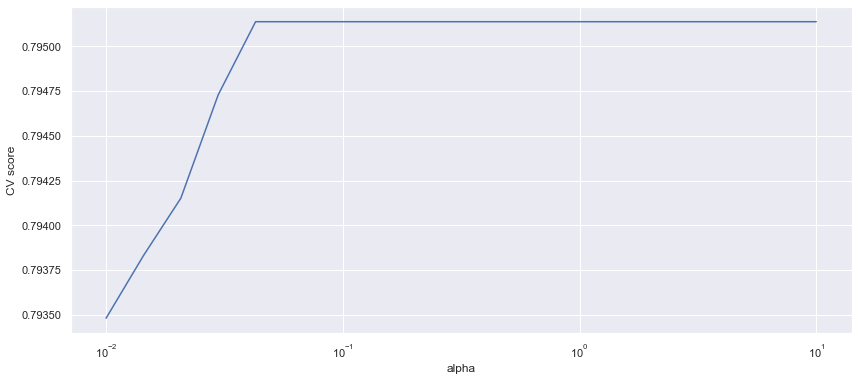

In [159]:
alphas = np.logspace(-2, 1, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [160]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7966


We found the vlaue of best alpha but did not see a big difference between the RMSE for both base model and with best hyperparameters for Lasso regression.

In [150]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = ridge_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE = 0.7945


Best alpha = 88.5867


Text(0, 0.5, 'CV score')

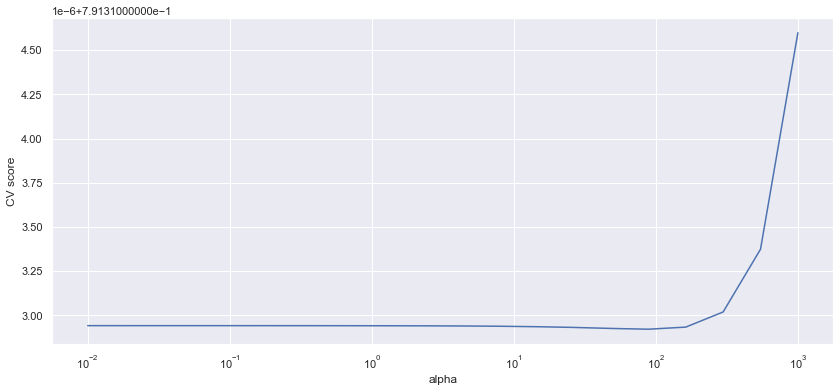

In [157]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(ridge_pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [158]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7965


We found the value for the best alpha, but again we see a minor improvement in the model. An important factor here is to see if we can add more variables to improve the 
model.

**Task 8**. Find data, which describes weather in New York during 2016 year. Add some features, based on this data and find new quality of your best model.

In [212]:
#your code is here
#Weather data in New York City - 2016

weather = pd.read_csv("weather_data_nyc_centralpark_2016(1).csv")
weather.head(5)
#end of your code

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38,0.00,0.0,0
1,2-1-2016,40,32,36,0.00,0.0,0
2,3-1-2016,45,35,40,0.00,0.0,0
3,4-1-2016,36,14,25,0.00,0.0,0
4,5-1-2016,29,11,20,0.00,0.0,0


In [213]:
weather['precipitation'] = pd.to_numeric(weather['precipitation'], errors='coerce')
weather['snow fall'] = pd.to_numeric(weather['snow fall'], errors='coerce')
weather['snow depth'] = pd.to_numeric(weather['snow depth'], errors='coerce')
weather = weather.fillna(0)

In [214]:
weather.head(6)

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38,0,0,0
1,2-1-2016,40,32,36,0,0,0
2,3-1-2016,45,35,40,0,0,0
3,4-1-2016,36,14,25,0,0,0
4,5-1-2016,29,11,20,0,0,0
5,6-1-2016,41,25,33,0,0,0


In [215]:
weather["date"] = pd.to_datetime(weather["date"])
weather['year'] = weather['date'].dt.year
weather_2016 = weather[weather["year"] == 2016]
weather_2016.drop(["year"], axis=1, inplace=True)

In [216]:
train_new['pickup_datetime'] = pd.to_datetime(train_new.pickup_datetime)
train_new['year'] = train_new['pickup_datetime'].dt.year
train_new['day'] = train_new['pickup_datetime'].dt.day
train_new['month'] = train_new['pickup_datetime'].dt.month

In [217]:
train_new['date']=pd.to_datetime(train_new[['year','month','day']],errors='coerce')
left_merge = pd.merge(left=train_new, right=weather_2016, on="date", how="left")
train_weather_taxi = left_merge.loc[:, left_merge.columns != 'date']

In [218]:
train_weather_taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   10000 non-null  object        
 1   vendor_id            10000 non-null  int64         
 2   pickup_datetime      10000 non-null  datetime64[ns]
 3   dropoff_datetime     10000 non-null  object        
 4   passenger_count      10000 non-null  int64         
 5   pickup_longitude     10000 non-null  float64       
 6   pickup_latitude      10000 non-null  float64       
 7   dropoff_longitude    10000 non-null  float64       
 8   dropoff_latitude     10000 non-null  float64       
 9   store_and_fwd_flag   10000 non-null  object        
 10  trip_duration        10000 non-null  int64         
 11  year                 10000 non-null  int64         
 12  day                  10000 non-null  int64         
 13  distance             10000 non-n

In [219]:
import statsmodels.api as sm

In [ ]:
#NOTE: Distance is created in the next step so need to run task 9 before task 8

In [220]:
# ANOVA for variable selection
x1 = train_weather_taxi[['distance', 'month','pickup_longitude','passenger_count','vendor_id','pickup_latitude', 'average temperature', 'maximum temperature', 'minimum temperature', 'dropoff_longitude','dropoff_latitude','precipitation','snow depth','snow fall']]
y1=train_weather_taxi['trip_duration']
x=sm.add_constant(x1)
model=sm.OLS(y1,x1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          trip_duration   R-squared (uncentered):                   0.085
Model:                            OLS   Adj. R-squared (uncentered):              0.083
Method:                 Least Squares   F-statistic:                              71.01
Date:                Mon, 31 Oct 2022   Prob (F-statistic):                   1.80e-180
Time:                        10:01:03   Log-Likelihood:                         -94697.
No. Observations:               10000   AIC:                                  1.894e+05
Df Residuals:                    9987   BIC:                                  1.895e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
distance               -0.9145      7.518     -0.122      0.903     -15.652      13.823
month                  42.3288     21.844      1.938      0.053      -0.490      85.148
pickup_longitude     1551.3304    771.986      2.010      0.045      38.082    3064.579
passenger_count        16.7457     24.802      0.675      0.500     -31.870      65.362
vendor_id             206.1767     65.849      3.131      0.002      77.100     335.254
pickup_latitude       376.8535   1210.001      0.311      0.755   -1994.993    2748.700
average temperature    -0.3009      0.751     -0.401      0.689      -1.773       1.171
maximum temperature     2.4743      6.178      0.400      0.689      -9.636      14.584
minimum temperature    -3.0762      6.398     -0.481      0.631     -15.618       9.465
dropoff_longitude   -2000.5883    695.854     -2.875      0.004   -3364.603    -636.574
dropoff_latitude    -1180.9120    984.577     -1.199      0.230   -3110.881     749.057
precipitation        -189.6616    142.398     -1.332      0.183    -468.790      89.467
snow depth             10.6927     15.050      0.710      0.477     -18.809      40.194
snow fall              23.2934     39.622      0.588      0.557     -54.373     100.960
==============================================================================
Omnibus:                    24207.939   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        194287466.642
Skew:                          25.518   Prob(JB):                         0.00
Kurtosis:                     683.944   Cond. No.                     1.32e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.36e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Task 9**. Use information about start and end points of trip (with help of the function below (use small part of data) to create at least one new feature which will increase your quality. Study its correlation with the target, explain the results logically, test different encoding options and find your best quality.

In [221]:
features=["vendor_id", "passenger_count", "pickup_longitude", "pickup_latitude","dropoff_longitude",
"dropoff_latitude","distance","month","precipitation", "snow fall", "snow depth"] 
x_train_w=train_weather_taxi[features]
y_train_w=train_weather_taxi['trip_duration']

In [224]:
model_w=LinearRegression()
model=model_w.fit(x_train_w,y_train_w)
pred=model_w.predict(x_train_w)
accuracy=round(model_w.score(x_train_w,y_train_w)*100,2)
print(accuracy)

1.43


In [197]:
!pip install folium

In [198]:
import folium

In [199]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [200]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [201]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

In [202]:
!pip install haversine

In [203]:
train_orig = pd.read_csv('train1.csv')

In [204]:
train_orig['pickup_datetime'] = pd.to_datetime(train_orig.pickup_datetime)
train_orig['year'] = train_orig['pickup_datetime'].dt.year
train_orig['day'] = train_orig['pickup_datetime'].dt.day
train['month'] = train['pickup_datetime'].dt.month

In [208]:
#your code is here
# Creating a variable for the disiance between two pickup and drop points using haversine formula
import haversine as hs
import itertools

# change data name here -  substitute it in train
train_dist = train_orig.sample(10000,random_state = 2701)
res = []
for i in list(range(len(train_dist))):
    pick =  np.array(train.loc[i,['pickup_longitude','dropoff_longitude']])
    drop = np.array(train.loc[i,[ 'pickup_latitude','dropoff_latitude']])
    a,b= zip(pick,drop)
    res.append(hs.haversine(a,b))

train_dist["distance"] = res
#end of your code

In [226]:
target = 'trip_duration'
train_dist

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,day,distance
384481,id2340132,2,2016-03-18 20:34:27,2016-03-18 20:50:04,1,-74,41,-74,41,N,937,2016,18,1.9
317920,id3923907,2,2016-05-19 17:30:38,2016-05-19 18:43:03,1,-74,41,-74,41,N,4345,2016,19,2.1
1120631,id0471281,2,2016-02-11 22:19:51,2016-02-11 22:36:30,6,-74,41,-74,41,N,999,2016,11,3.4
796008,id2582688,1,2016-04-09 23:08:12,2016-04-09 23:14:37,2,-74,41,-74,41,N,385,2016,9,0.48
1345661,id1359731,1,2016-05-11 14:30:47,2016-05-11 14:55:33,1,-74,41,-74,41,N,1486,2016,11,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317578,id0320325,1,2016-02-11 08:52:17,2016-02-11 09:28:12,1,-74,41,-74,41,N,2155,2016,11,5.4
1250204,id1024597,1,2016-06-09 09:03:47,2016-06-09 09:19:06,2,-74,41,-74,41,N,919,2016,9,1.7
768430,id0074739,2,2016-02-16 18:20:52,2016-02-16 18:30:02,2,-74,41,-74,41,N,550,2016,16,0.6
1017131,id1839715,2,2016-05-28 10:45:37,2016-05-28 10:53:42,1,-74,41,-74,41,N,485,2016,28,0.77


In [230]:

train_new = pd.merge(train_orig,train_dist[["id","distance"]],on = 'id',how = "inner")
train_new[[target,"distance"]].corr()

,trip_duration,distance
trip_duration,1,-0.0013
distance,-0.0013,1


We see a slight negative correlation between distance and trip_duration